In [1]:
import json
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from scipy.optimize import curve_fit

In [2]:
def group_measurements(data):
    from collections import defaultdict
    grouped = defaultdict(list)
    
    for measurement in data:
        n_p = measurement['problem_size']['n_particles']
        layers = measurement['problem_size']['layers']
        N = measurement['problem_size']['matrix_size']
        P_succ = measurement['measurement_stats']['success_rate']
        grouped[(n_p, layers, N)].append(P_succ)
    
    result = {
        'n_particles': [], 'layers': [], 'N': [], 'M': [],
        'P_succ_mean': [], 'P_succ_std': [], 'P_succ_sem': []
    }
    
    for (n_p, layers, N), P_values in sorted(grouped.items()):
        result['n_particles'].append(n_p)
        result['layers'].append(layers)
        result['N'].append(N)
        result['M'].append(n_p * (layers - 1))
        result['P_succ_mean'].append(np.mean(P_values))
        result['P_succ_std'].append(np.std(P_values, ddof=1))
        result['P_succ_sem'].append(np.std(P_values, ddof=1) / np.sqrt(len(P_values)))
    
    return {k: np.array(v) for k, v in result.items()}

class GateCountFit:
    """Gate count fit: Gates = a·N^b·log(N) + d, with log power c=1.0 fixed, b fitted"""
    
    def __init__(self):
        self.c_fixed = 1.0
    
    def model(self, N, a, b, d):
        return a * np.power(N, b) * np.power(np.log(N), self.c_fixed) + d
    
    def fit(self, N, gates):
        # Initial guess: b~0.5 (from theory)
        p0 = [1.0, 0.5, 0.0]
        popt, pcov = curve_fit(self.model, N, gates, p0=p0, maxfev=50000)
        return popt, pcov
    
    def confidence_band(self, N, popt, pcov):
        a, b, d = popt
        y_fit = self.model(N, a, b, d)
        
        # Jacobian matrix for error propagation
        J = np.array([
            np.power(N, b) * np.log(N),  # ∂G/∂a
            a * np.power(N, b) * np.log(N)**2,  # ∂G/∂b
            np.ones_like(N)  # ∂G/∂d
        ]).T
        
        y_var = np.sum((J @ pcov) * J, axis=1)
        y_std = np.sqrt(np.abs(y_var))
        
        margin = 1.96 * y_std
        return y_fit, y_fit - margin, y_fit + margin

class SuccessProbabilityFit:
    """Success probability fit: P_succ = a × N^b, both a and b fitted"""
    
    def __init__(self, layers):
        self.layers = layers
    
    def model(self, N, a, b):
        return a * np.power(N, b)
    
    def fit(self, N, M, P_succ, P_succ_err):
        weights = 1.0 / (P_succ_err**2 + 1e-10)
        sigma = 1.0 / np.sqrt(weights)
        
        # Initial guess: b ~ -0.5 (from theory)
        a_init = P_succ[0] * np.sqrt(N[0])
        p0 = [a_init, -0.5]
        
        popt, pcov = curve_fit(
            self.model, N, P_succ,
            p0=p0, sigma=sigma,
            absolute_sigma=True, maxfev=50000
        )
        
        a, b = popt
        a_err = np.sqrt(pcov[0, 0])
        b_err = np.sqrt(pcov[1, 1])
        
        return a, b, a_err, b_err, pcov
    
    def confidence_band(self, N, a, b, pcov):
        P_fit = self.model(N, a, b)
        
        # Jacobian for error propagation
        dP_da = np.power(N, b)
        dP_db = a * np.power(N, b) * np.log(N)
        
        J = np.array([dP_da, dP_db]).T
        
        P_var = np.sum((J @ pcov) * J, axis=1)
        P_std = np.sqrt(np.abs(P_var))
        
        margin = 1.96 * P_std
        
        return P_fit, P_fit - margin, P_fit + margin
    
    def extract_c_filter(self, a, b, a_err, b_err, N_ref):
        """
        Extract c_filter from fit at reference N.
        P = a × N^b ≈ (1/2) × c_filter × √(ℓ-1) / √N  (if b ≈ -0.5)
        """
        sqrt_l_minus_1 = np.sqrt(self.layers - 1)
        
        # c_filter derived at N_ref
        c_filter = 2 * a * np.power(N_ref, b + 0.5) / sqrt_l_minus_1
        
        # Error propagation
        dc_da = 2 * np.power(N_ref, b + 0.5) / sqrt_l_minus_1
        dc_db = 2 * a * np.power(N_ref, b + 0.5) * np.log(N_ref) / sqrt_l_minus_1
        
        c_filter_err = np.sqrt(dc_da**2 * a_err**2 + dc_db**2 * b_err**2)
        
        return c_filter, c_filter_err
    
    def calculate_r2(self, N, P_succ, a, b):
        P_pred = self.model(N, a, b)
        ss_res = np.sum((P_succ - P_pred)**2)
        ss_tot = np.sum((P_succ - np.mean(P_succ))**2)
        return 1 - (ss_res / ss_tot)
    
    def calculate_chi2_dof(self, N, P_succ, P_succ_err, a, b):
        P_pred = self.model(N, a, b)
        residuals = P_succ - P_pred
        
        chi2 = np.sum((residuals / P_succ_err)**2)
        dof = len(N) - 2  # 2 parameters: a, b
        chi2_reduced = chi2 / dof if dof > 0 else np.nan
        
        return chi2_reduced, dof

def calc_r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - (ss_res / ss_tot)


In [3]:
# =============================================================================
# CONFIGURATION
# =============================================================================
FIT_POWER_LAW = True 

# =============================================================================
# LOAD DATA FOR GATE COUNT COMPLEXITY
# =============================================================================

with open('../data/circuit_depth.json', 'r') as f:
    metrics_general = json.load(f)

data_3L_gates = [m for m in metrics_general if m['problem_size']['layers'] == 3]
data_5L_gates = [m for m in metrics_general if m['problem_size']['layers'] == 5]

matrix_size_3L_gates = np.array([m['problem_size']['matrix_size'] for m in data_3L_gates])
n_particles_3L_gates = [m['problem_size']['n_particles'] for m in data_3L_gates]
two_qubit_qiskit_3L = np.array([m['standard']['hardware_torino']['two_qubit_gates'] for m in data_3L_gates])
two_qubit_tket_3L = np.array([m['standard']['tket']['two_qubit_gates'] for m in data_3L_gates])

matrix_size_5L_gates = np.array([m['problem_size']['matrix_size'] for m in data_5L_gates])
n_particles_5L_gates = [m['problem_size']['n_particles'] for m in data_5L_gates]
two_qubit_qiskit_5L = np.array([m['standard']['hardware_torino']['two_qubit_gates'] for m in data_5L_gates])
two_qubit_tket_5L = np.array([m['standard']['tket']['two_qubit_gates'] for m in data_5L_gates])



In [4]:
# =============================================================================
# LOAD DATA FOR SUCCESS PROBABILITY
# =============================================================================

with open('../data/success_counts.json', 'r') as f:
    measurement_data = json.load(f)

data_3L_prob = [m for m in measurement_data if m['problem_size']['layers'] == 3]
data_5L_prob = [m for m in measurement_data if m['problem_size']['layers'] == 5]
stats_3L_prob = group_measurements(data_3L_prob)
stats_5L_prob = group_measurements(data_5L_prob)

N_3L_prob = stats_3L_prob['N']
M_3L_prob = stats_3L_prob['M']
P_succ_3L = stats_3L_prob['P_succ_mean']
P_succ_err_3L = stats_3L_prob['P_succ_sem']
n_particles_3L_prob = stats_3L_prob['n_particles']

N_5L_prob = stats_5L_prob['N']
M_5L_prob = stats_5L_prob['M']
P_succ_5L = stats_5L_prob['P_succ_mean']
P_succ_err_5L = stats_5L_prob['P_succ_sem']
n_particles_5L_prob = stats_5L_prob['n_particles']

print(f"\n{'='*70}")
print(f"DATA SUMMARY")
print(f"{'='*70}")
print(f"  3 Layers: {len(N_3L_prob)} unique problem sizes")
print(f"            m range: {n_particles_3L_prob.min()} to {n_particles_3L_prob.max()}")
print(f"            M = 2m range: {M_3L_prob.min()} to {M_3L_prob.max()}")
print(f"            N range: {N_3L_prob.min()} to {N_3L_prob.max()}")
print(f"  5 Layers: {len(N_5L_prob)} unique problem sizes")
print(f"            m range: {n_particles_5L_prob.min()} to {n_particles_5L_prob.max()}")
print(f"            M = 4m range: {M_5L_prob.min()} to {M_5L_prob.max()}")
print(f"            N range: {N_5L_prob.min()} to {N_5L_prob.max()}")


DATA SUMMARY
  3 Layers: 10 unique problem sizes
            m range: 2 to 1024
            M = 2m range: 4 to 2048
            N range: 8 to 2097152
  5 Layers: 10 unique problem sizes
            m range: 2 to 1024
            M = 4m range: 8 to 4096
            N range: 16 to 4194304


In [5]:
# =============================================================================
# PERFORM FITS
# =============================================================================

print("\n" + "="*70)
print("FITTING GATE COUNT COMPLEXITY (CONSTRAINED LOG)")
print("Model: G = a·N^b·log(N) + d  (c=1.0 fixed, b fitted)")
print("="*70)

fit_gates = GateCountFit()

popt_qiskit_3L, pcov_qiskit_3L = fit_gates.fit(matrix_size_3L_gates, two_qubit_qiskit_3L)
popt_qiskit_5L, pcov_qiskit_5L = fit_gates.fit(matrix_size_5L_gates, two_qubit_qiskit_5L)
popt_tket_3L, pcov_tket_3L = fit_gates.fit(matrix_size_3L_gates, two_qubit_tket_3L)
popt_tket_5L, pcov_tket_5L = fit_gates.fit(matrix_size_5L_gates, two_qubit_tket_5L)

r2_qiskit_3L = calc_r2(two_qubit_qiskit_3L, fit_gates.model(matrix_size_3L_gates, *popt_qiskit_3L))
r2_qiskit_5L = calc_r2(two_qubit_qiskit_5L, fit_gates.model(matrix_size_5L_gates, *popt_qiskit_5L))
r2_tket_3L = calc_r2(two_qubit_tket_3L, fit_gates.model(matrix_size_3L_gates, *popt_tket_3L))
r2_tket_5L = calc_r2(two_qubit_tket_5L, fit_gates.model(matrix_size_5L_gates, *popt_tket_5L))

print(f"Qiskit 3L: R² = {r2_qiskit_3L:.6f}, b = {popt_qiskit_3L[1]:.3f}±{np.sqrt(pcov_qiskit_3L[1,1]):.3f}")
print(f"Qiskit 5L: R² = {r2_qiskit_5L:.6f}, b = {popt_qiskit_5L[1]:.3f}±{np.sqrt(pcov_qiskit_5L[1,1]):.3f}")
print(f"TKET 3L:   R² = {r2_tket_3L:.6f}, b = {popt_tket_3L[1]:.3f}±{np.sqrt(pcov_tket_3L[1,1]):.3f}")
print(f"TKET 5L:   R² = {r2_tket_5L:.6f}, b = {popt_tket_5L[1]:.3f}±{np.sqrt(pcov_tket_5L[1,1]):.3f}")

print("\n" + "="*70)
print("FITTING SUCCESS PROBABILITY (FIT EXPONENT)")
print("Model: P_succ = a × N^b  (both a and b fitted)")
print("="*70)


FITTING GATE COUNT COMPLEXITY (CONSTRAINED LOG)
Model: G = a·N^b·log(N) + d  (c=1.0 fixed, b fitted)
Qiskit 3L: R² = 0.999854, b = 0.528±0.008
Qiskit 5L: R² = 0.999756, b = 0.577±0.013
TKET 3L:   R² = 0.999992, b = 0.524±0.002
TKET 5L:   R² = 0.999991, b = 0.518±0.002

FITTING SUCCESS PROBABILITY (FIT EXPONENT)
Model: P_succ = a × N^b  (both a and b fitted)


In [6]:
fit_prob_3L = SuccessProbabilityFit(layers=3)
fit_prob_5L = SuccessProbabilityFit(layers=5)

a_3L, b_3L, a_err_3L, b_err_3L, pcov_3L_prob = fit_prob_3L.fit(N_3L_prob, M_3L_prob, P_succ_3L, P_succ_err_3L)
a_5L, b_5L, a_err_5L, b_err_5L, pcov_5L_prob = fit_prob_5L.fit(N_5L_prob, M_5L_prob, P_succ_5L, P_succ_err_5L)

# Use geometric mean as reference for c_filter extraction
N_ref_3L = np.sqrt(N_3L_prob.min() * N_3L_prob.max())
N_ref_5L = np.sqrt(N_5L_prob.min() * N_5L_prob.max())

c_filter_3L, c_filter_err_3L = fit_prob_3L.extract_c_filter(a_3L, b_3L, a_err_3L, b_err_3L, N_ref_3L)
c_filter_5L, c_filter_err_5L = fit_prob_5L.extract_c_filter(a_5L, b_5L, a_err_5L, b_err_5L, N_ref_5L)

r2_prob_3L = fit_prob_3L.calculate_r2(N_3L_prob, P_succ_3L, a_3L, b_3L)
r2_prob_5L = fit_prob_5L.calculate_r2(N_5L_prob, P_succ_5L, a_5L, b_5L)

chi2_3L, dof_3L = fit_prob_3L.calculate_chi2_dof(N_3L_prob, P_succ_3L, P_succ_err_3L, a_3L, b_3L)
chi2_5L, dof_5L = fit_prob_5L.calculate_chi2_dof(N_5L_prob, P_succ_5L, P_succ_err_5L, a_5L, b_5L)

pred_prob_3L = fit_prob_3L.model(N_3L_prob, a_3L, b_3L)
pred_prob_5L = fit_prob_5L.model(N_5L_prob, a_5L, b_5L)
res_prob_3L = (P_succ_3L - pred_prob_3L) / P_succ_3L * 100
res_prob_5L = (P_succ_5L - pred_prob_5L) / P_succ_5L * 100

max_rel_error_3L = np.max(np.abs(res_prob_3L))
mean_rel_error_3L = np.mean(np.abs(res_prob_3L))
max_rel_error_5L = np.max(np.abs(res_prob_5L))
mean_rel_error_5L = np.mean(np.abs(res_prob_5L))

print(f"\n3 LAYERS:")
print(f"  a = {a_3L:.6f} ± {a_err_3L:.6f}")
print(f"  b = {b_3L:.6f} ± {b_err_3L:.6f}  (expected: -0.5)")
print(f"  c_filter (derived @ N={N_ref_3L:.1f}) = {c_filter_3L:.4f}±{c_filter_err_3L:.4f}")
print(f"  R² = {r2_prob_3L:.6f}")
print(f"  χ²/dof = {chi2_3L/dof_3L:.3f} (dof = {dof_3L})")
print(f"  Max relative error: {max_rel_error_3L:.2f}%")
print(f"  Mean relative error: {mean_rel_error_3L:.2f}%")

print(f"\n5 LAYERS:")
print(f"  a = {a_5L:.6f} ± {a_err_5L:.6f}")
print(f"  b = {b_5L:.6f} ± {b_err_5L:.6f}  (expected: -0.5)")
print(f"  c_filter (derived @ N={N_ref_5L:.1f}) = {c_filter_5L:.4f}±{c_filter_err_5L:.4f}")
print(f"  R² = {r2_prob_5L:.6f}")
print(f"  χ²/dof = {chi2_5L/dof_5L:.3f} (dof = {dof_5L})")
print(f"  Max relative error: {max_rel_error_5L:.2f}%")
print(f"  Mean relative error: {mean_rel_error_5L:.2f}%")


3 LAYERS:
  a = 0.353374 ± 0.000113
  b = -0.499803 ± 0.000107  (expected: -0.5)
  c_filter (derived @ N=4096.0) = 0.5006±0.0005
  R² = 0.999977
  χ²/dof = 37.755 (dof = 8)
  Max relative error: 21.42%
  Mean relative error: 3.34%

5 LAYERS:
  a = 0.812351 ± 0.000179
  b = -0.499931 ± 0.000061  (expected: -0.5)
  c_filter (derived @ N=8192.0) = 0.8129±0.0005
  R² = 1.000000
  χ²/dof = 12.739 (dof = 8)
  Max relative error: 13.13%
  Mean relative error: 1.80%


In [7]:
# =============================================================================
# THEORETICAL COMPARISON
# =============================================================================

lambda_signal_3L = 3
lambda_c_3L = 2
lambda_signal_5L = 2.38196601
lambda_c_5L = 1.38196601

c_filter_theory_3L = np.cos(np.pi * lambda_signal_3L / (2 * lambda_c_3L))**2
c_filter_theory_5L = np.cos(np.pi * lambda_signal_5L / (2 * lambda_c_5L))**2

print(f"\n{'='*70}")
print(f"THEORETICAL vs EXPERIMENTAL COMPARISON")
print(f"{'='*70}")

print(f"\n3 LAYERS:")
print(f"  Theoretical c_filter = {c_filter_theory_3L:.6f}")
print(f"  Experimental c_filter = {c_filter_3L:.6f} ± {c_filter_err_3L:.6f}")
print(f"  Ratio (exp/theory): {c_filter_3L/c_filter_theory_3L:.4f}")
sigma_diff_3L = abs(c_filter_3L - c_filter_theory_3L) / c_filter_err_3L
print(f"  Deviation: {sigma_diff_3L:.2f}σ")
print(f"  b deviation from -0.5: {abs(b_3L + 0.5)/b_err_3L:.2f}σ")

print(f"\n5 LAYERS:")
print(f"  Theoretical c_filter = {c_filter_theory_5L:.6f}")
print(f"  Experimental c_filter = {c_filter_5L:.6f} ± {c_filter_err_5L:.6f}")
print(f"  Ratio (exp/theory): {c_filter_5L/c_filter_theory_5L:.4f}")
sigma_diff_5L = abs(c_filter_5L - c_filter_theory_5L) / c_filter_err_5L
print(f"  Deviation: {sigma_diff_5L:.2f}σ")
print(f"  b deviation from -0.5: {abs(b_5L + 0.5)/b_err_5L:.2f}σ")

# =============================================================================
# GENERATE SMOOTH CURVES
# =============================================================================

N_smooth_gates = np.logspace(
    np.log10(min(matrix_size_3L_gates.min(), matrix_size_5L_gates.min())),
    np.log10(max(matrix_size_3L_gates.max(), matrix_size_5L_gates.max())),
    200
)

N_smooth_prob = np.logspace(
    np.log10(min(N_3L_prob.min(), N_5L_prob.min())),
    np.log10(max(N_3L_prob.max(), N_5L_prob.max())),
    200
)

# Confidence bands
fit_qiskit_3L, lower_qiskit_3L, upper_qiskit_3L = fit_gates.confidence_band(N_smooth_gates, popt_qiskit_3L, pcov_qiskit_3L)
fit_qiskit_5L, lower_qiskit_5L, upper_qiskit_5L = fit_gates.confidence_band(N_smooth_gates, popt_qiskit_5L, pcov_qiskit_5L)
fit_tket_3L, lower_tket_3L, upper_tket_3L = fit_gates.confidence_band(N_smooth_gates, popt_tket_3L, pcov_tket_3L)
fit_tket_5L, lower_tket_5L, upper_tket_5L = fit_gates.confidence_band(N_smooth_gates, popt_tket_5L, pcov_tket_5L)

fit_prob_3L_smooth, lower_prob_3L, upper_prob_3L = fit_prob_3L.confidence_band(N_smooth_prob, a_3L, b_3L, pcov_3L_prob)
fit_prob_5L_smooth, lower_prob_5L, upper_prob_5L = fit_prob_5L.confidence_band(N_smooth_prob, a_5L, b_5L, pcov_5L_prob)


THEORETICAL vs EXPERIMENTAL COMPARISON

3 LAYERS:
  Theoretical c_filter = 0.500000
  Experimental c_filter = 0.500566 ± 0.000473
  Ratio (exp/theory): 1.0011
  Deviation: 1.20σ
  b deviation from -0.5: 1.84σ

5 LAYERS:
  Theoretical c_filter = 0.823057
  Experimental c_filter = 0.812858 ± 0.000483
  Ratio (exp/theory): 0.9876
  Deviation: 21.13σ
  b deviation from -0.5: 1.13σ


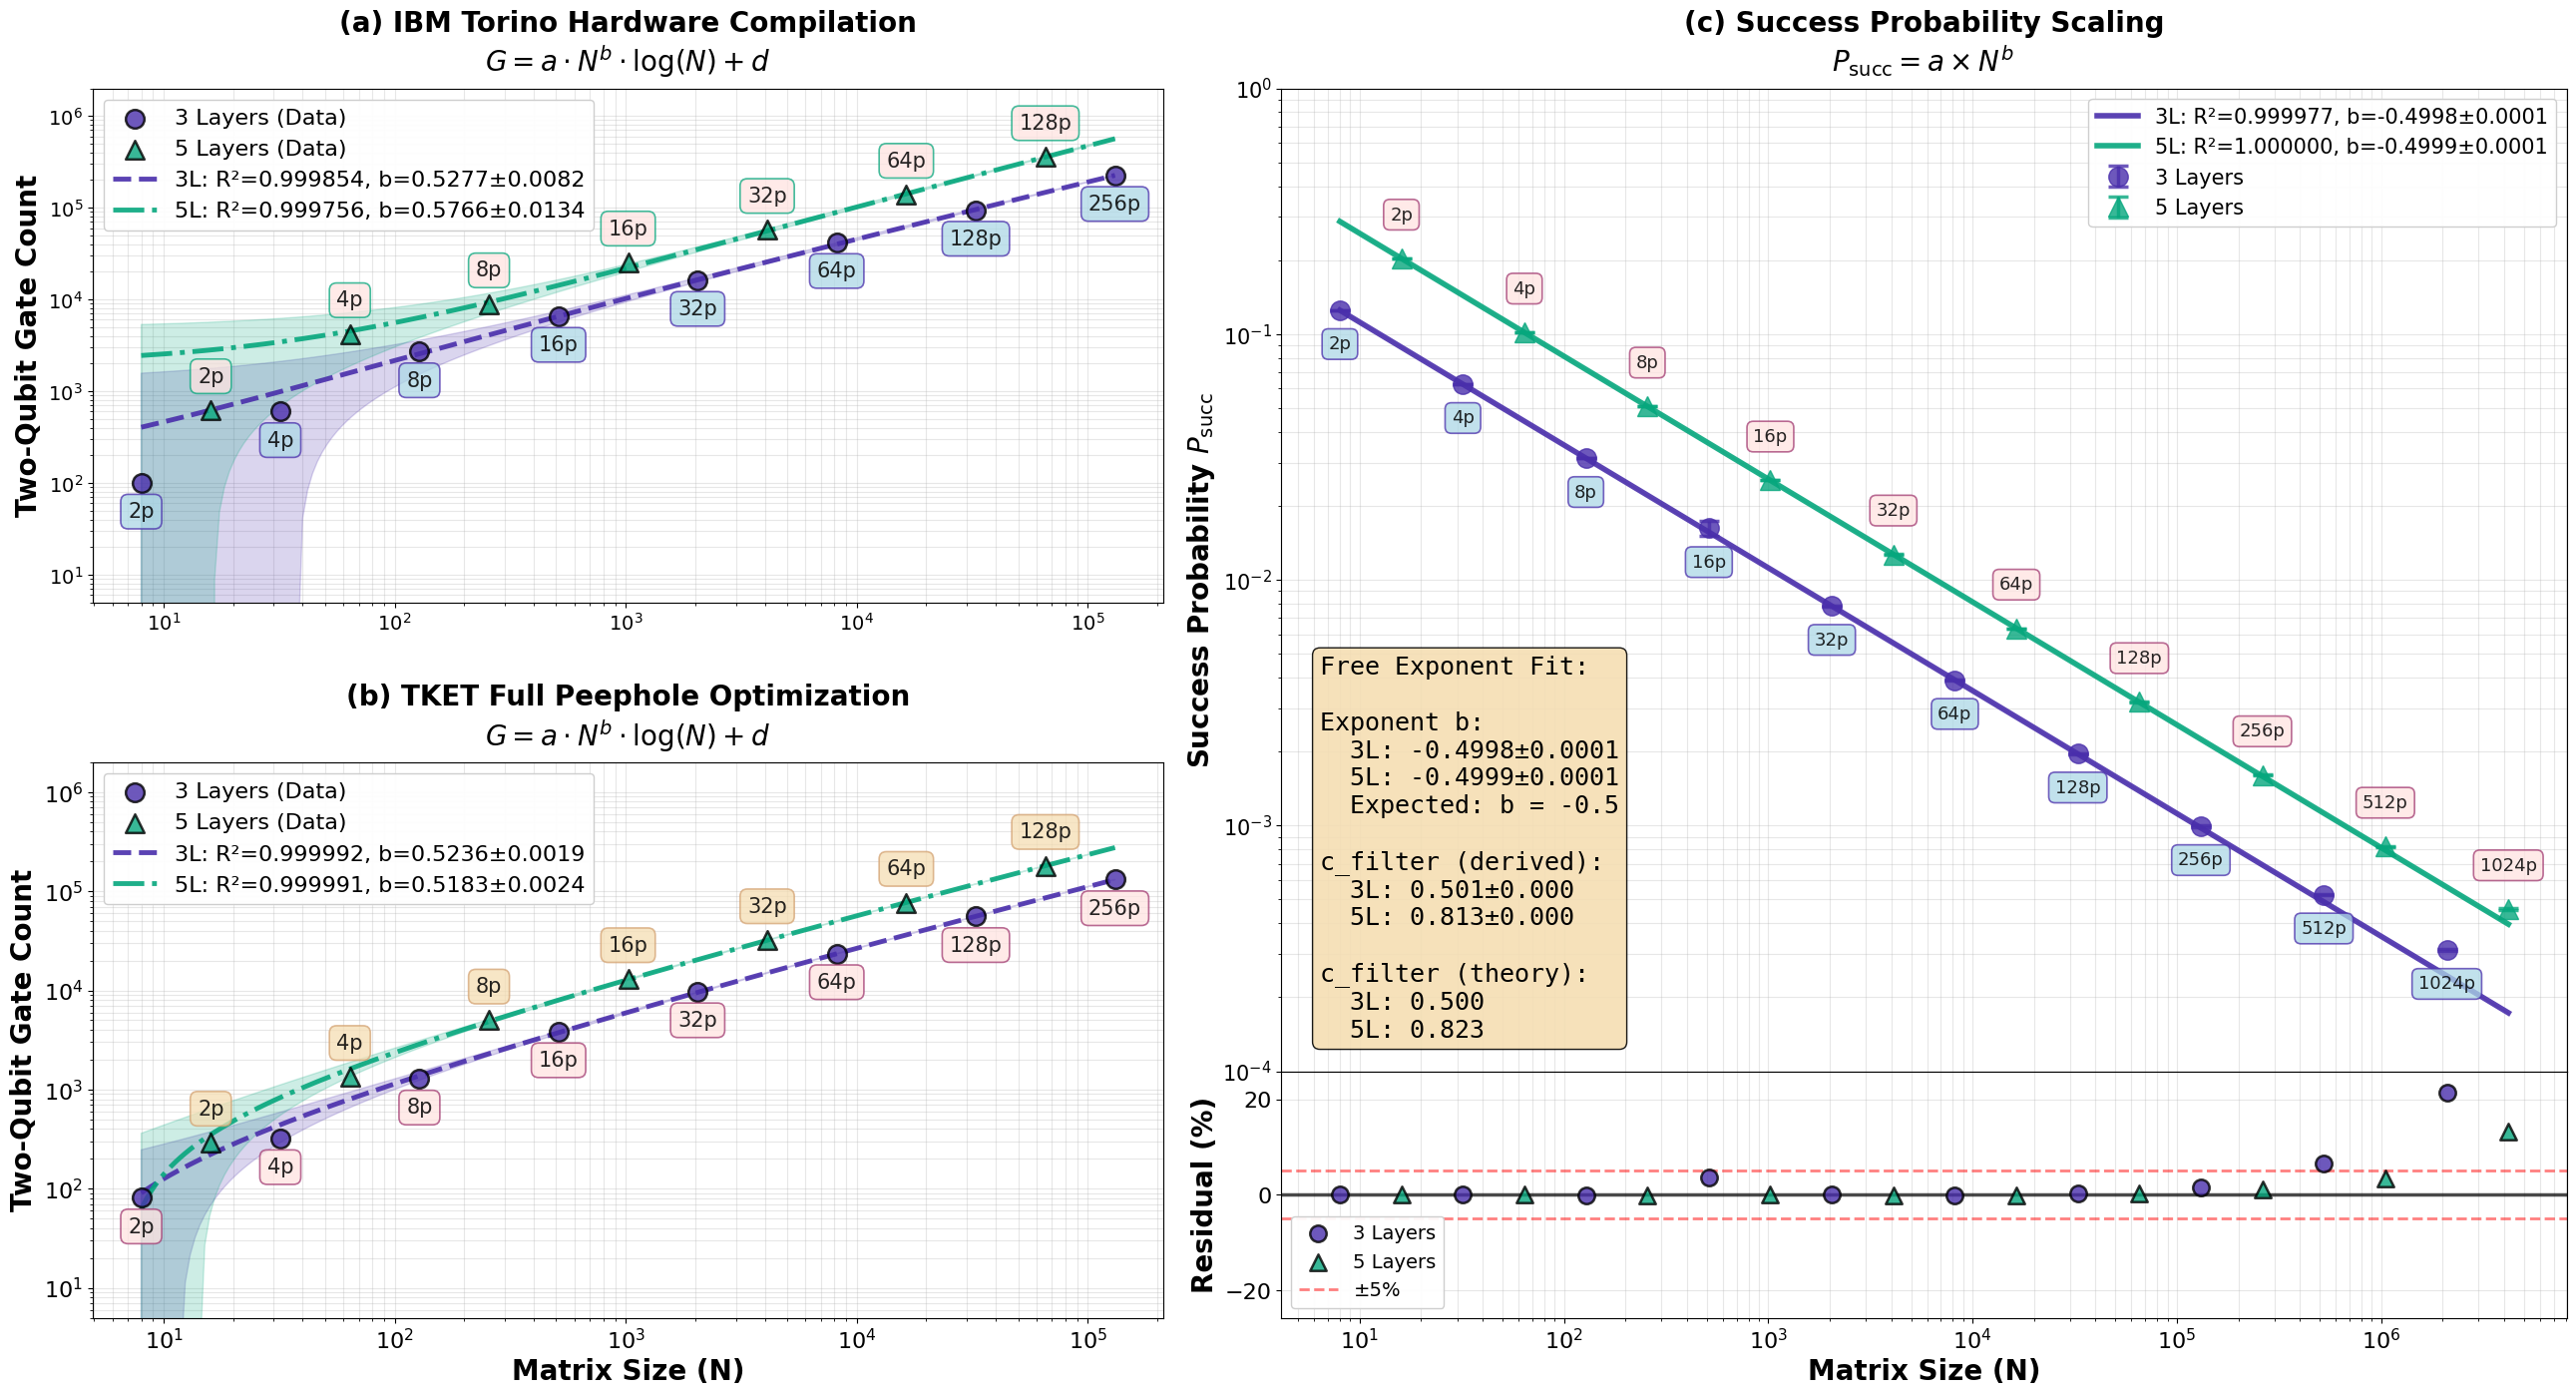

In [8]:

fig = plt.figure(figsize=(32, 16))

gs = gridspec.GridSpec(4, 2, 
                       height_ratios=[1, 0.15, 1, 0.00001],  
                       width_ratios=[1.0, 1.2],  
                       hspace=0.15, wspace=0.10)

gs_right = gridspec.GridSpecFromSubplotSpec(2, 1,
                                            subplot_spec=gs[:, 1],  # Span all rows in column 1
                                            height_ratios=[4, 1],  # Main plot 3x larger than residual
                                            hspace=0.001)

#fig.suptitle('Circuit Complexity and Success Probability Scaling\n',
#             fontsize=24, fontweight='bold', y=0.97)

# =============================================================================
# LEFT TOP: QISKIT GATE COUNT
# =============================================================================

ax_q_main = fig.add_subplot(gs[0, 0])

ax_q_main.scatter(matrix_size_3L_gates, two_qubit_qiskit_3L, marker='o', s=180,
                 label='3 Layers (Data)', alpha=0.8, color="#492EAB",
                 edgecolors='black', linewidth=1.8, zorder=5)
ax_q_main.scatter(matrix_size_5L_gates, two_qubit_qiskit_5L, marker='^', s=180,
                 label='5 Layers (Data)', alpha=0.8, color='#06A77D',
                 edgecolors='black', linewidth=1.8, zorder=5)

ax_q_main.plot(N_smooth_gates, fit_qiskit_3L, '--', linewidth=3.5, alpha=0.9, color='#492EAB',
              label=f'3L: R²={r2_qiskit_3L:.6f}, b={popt_qiskit_3L[1]:.4f}±{np.sqrt(pcov_qiskit_3L[1,1]):.4f}', zorder=3)
ax_q_main.fill_between(N_smooth_gates, lower_qiskit_3L, upper_qiskit_3L,
                       alpha=0.2, color='#492EAB', zorder=2)

ax_q_main.plot(N_smooth_gates, fit_qiskit_5L, '-.', linewidth=3.5, alpha=0.9, color='#06A77D',
              label=f'5L: R²={r2_qiskit_5L:.6f}, b={popt_qiskit_5L[1]:.4f}±{np.sqrt(pcov_qiskit_5L[1,1]):.4f}', zorder=3)
ax_q_main.fill_between(N_smooth_gates, lower_qiskit_5L, upper_qiskit_5L,
                       alpha=0.2, color='#06A77D', zorder=2)
    
for i, (ms, n_p) in enumerate(zip(matrix_size_3L_gates, n_particles_3L_gates)):
    ax_q_main.annotate(f'{n_p}p', (ms, two_qubit_qiskit_3L[i]),
                      textcoords="offset points", xytext=(0, -25),
                      ha='center', fontsize=15, alpha=0.85,
                      bbox=dict(boxstyle='round,pad=0.35', facecolor='lightblue',
                               alpha=0.75, edgecolor='#492EAB', linewidth=1.2), zorder=6)

for i, (ms, n_p) in enumerate(zip(matrix_size_5L_gates, n_particles_5L_gates)):
    ax_q_main.annotate(f'{n_p}p', (ms, two_qubit_qiskit_5L[i]),
                      textcoords="offset points", xytext=(0, 20),
                      ha='center', fontsize=15, alpha=0.85,
                      bbox=dict(boxstyle='round,pad=0.35', facecolor='#FFE4E1',
                               alpha=0.75, edgecolor='#06A77D', linewidth=1.2), zorder=6)

ax_q_main.set_ylabel('Two-Qubit Gate Count', fontsize=20, fontweight='bold')
ax_q_main.set_title('(a) IBM Torino Hardware Compilation\n' + 
                    r'$G = a \cdot N^{b} \cdot \log(N) + d$',
                    fontsize=20, fontweight='bold', pad=12)
ax_q_main.legend(loc='upper left', fontsize=16, framealpha=0.95)
ax_q_main.grid(True, alpha=0.3, which='both', zorder=0)
ax_q_main.set_xscale('log')
ax_q_main.set_yscale('log')
ax_q_main.set_ylim(5e0, 2e6)
ax_q_main.tick_params(labelsize=14)

# =============================================================================
# LEFT BOTTOM: TKET GATE COUNT
# =============================================================================

ax_t_main = fig.add_subplot(gs[2:4, 0])

ax_t_main.scatter(matrix_size_3L_gates, two_qubit_tket_3L, marker='o', s=180,
                 label='3 Layers (Data)', alpha=0.8, color='#492EAB',
                 edgecolors='black', linewidth=1.8, zorder=5)
ax_t_main.scatter(matrix_size_5L_gates, two_qubit_tket_5L, marker='^', s=180,
                 label='5 Layers (Data)', alpha=0.8, color='#06A77D',
                 edgecolors='black', linewidth=1.8, zorder=5)

ax_t_main.plot(N_smooth_gates, fit_tket_3L, '--', linewidth=3.5, alpha=0.9, color='#492EAB',
              label=f'3L: R²={r2_tket_3L:.6f}, b={popt_tket_3L[1]:.4f}±{np.sqrt(pcov_tket_3L[1,1]):.4f}', zorder=3)
ax_t_main.fill_between(N_smooth_gates, lower_tket_3L, upper_tket_3L,
                       alpha=0.2, color='#492EAB', zorder=2)

ax_t_main.plot(N_smooth_gates, fit_tket_5L, '-.', linewidth=3.5, alpha=0.9, color='#06A77D',
              label=f'5L: R²={r2_tket_5L:.6f}, b={popt_tket_5L[1]:.4f}±{np.sqrt(pcov_tket_5L[1,1]):.4f}', zorder=3)
ax_t_main.fill_between(N_smooth_gates, lower_tket_5L, upper_tket_5L,
                       alpha=0.2, color='#06A77D', zorder=2)

for i, (ms, n_p) in enumerate(zip(matrix_size_3L_gates, n_particles_3L_gates)):
    ax_t_main.annotate(f'{n_p}p', (ms, two_qubit_tket_3L[i]),
                      textcoords="offset points", xytext=(0, -25),
                      ha='center', fontsize=15, alpha=0.85,
                      bbox=dict(boxstyle='round,pad=0.35', facecolor='#FFE4E1',
                               alpha=0.75, edgecolor='#A23B72', linewidth=1.2), zorder=6)

for i, (ms, n_p) in enumerate(zip(matrix_size_5L_gates, n_particles_5L_gates)):
    ax_t_main.annotate(f'{n_p}p', (ms, two_qubit_tket_5L[i]),
                      textcoords="offset points", xytext=(0, 20),
                      ha='center', fontsize=15, alpha=0.85,
                      bbox=dict(boxstyle='round,pad=0.35', facecolor='wheat',
                               alpha=0.75, edgecolor='#D4A373', linewidth=1.2), zorder=6)

ax_t_main.set_xlabel('Matrix Size (N)', fontsize=20, fontweight='bold')
ax_t_main.set_ylabel('Two-Qubit Gate Count', fontsize=20, fontweight='bold')
ax_t_main.set_title('(b) TKET Full Peephole Optimization\n' + 
                    r'$G = a \cdot N^{b} \cdot \log(N) + d$',
                    fontsize=20, fontweight='bold', pad=12)
ax_t_main.legend(loc='upper left', fontsize=16, framealpha=0.95)
ax_t_main.grid(True, alpha=0.3, which='both', zorder=0)
ax_t_main.set_xscale('log')
ax_t_main.set_yscale('log')
ax_t_main.set_ylim(5e0, 2e6)
ax_t_main.tick_params(labelsize=16)

# =============================================================================
# RIGHT TOP: SUCCESS PROBABILITY
# =============================================================================

ax_p_main = fig.add_subplot(gs_right[0])#gs[0:3, 1])
ax_p_res = fig.add_subplot(gs_right[1], sharex=ax_p_main)
    
# Main plot
ax_p_main.errorbar(N_3L_prob, P_succ_3L, yerr=1.96*P_succ_err_3L, fmt='o', markersize=14,
                  label='3 Layers', alpha=0.8, color='#492EAB',
                  ecolor='#492EAB', capsize=7, capthick=2.5, elinewidth=2.5, zorder=5)

ax_p_main.plot(N_smooth_prob, fit_prob_3L_smooth, '-', linewidth=4, alpha=0.9, color='#492EAB',
              label=f'3L: R²={r2_prob_3L:.6f}, b={b_3L:.4f}±{b_err_3L:.4f}', zorder=3)
ax_p_main.fill_between(N_smooth_prob, lower_prob_3L, upper_prob_3L,
                      alpha=0.2, color='#492EAB', zorder=2)

ax_p_main.errorbar(N_5L_prob, P_succ_5L, yerr=1.96*P_succ_err_5L, fmt='^', markersize=14,
                  label='5 Layers', alpha=0.8, color='#06A77D',
                  ecolor='#06A77D', capsize=7, capthick=2.5, elinewidth=2.5, zorder=5)
ax_p_main.plot(N_smooth_prob, fit_prob_5L_smooth, '-', linewidth=4, alpha=0.9, color='#06A77D',
              label=f'5L: R²={r2_prob_5L:.6f}, b={b_5L:.4f}±{b_err_5L:.4f}', zorder=3)
ax_p_main.fill_between(N_smooth_prob, lower_prob_5L, upper_prob_5L,
                      alpha=0.2, color='#06A77D', zorder=2)
# Annotations
for i, (N_val, P_val, m_val) in enumerate(zip(N_3L_prob, P_succ_3L, n_particles_3L_prob)):
    ax_p_main.annotate(f'{m_val}p', (N_val, P_val),
                      textcoords="offset points", xytext=(0, -28),
                      ha='center', fontsize=13, alpha=0.85,
                      bbox=dict(boxstyle='round,pad=0.35', facecolor='lightblue',
                               alpha=0.75, edgecolor='#492EAB', linewidth=1.2), zorder=6)

for i, (N_val, P_val, m_val) in enumerate(zip(N_5L_prob, P_succ_5L, n_particles_5L_prob)):
    ax_p_main.annotate(f'{m_val}p', (N_val, P_val),
                      textcoords="offset points", xytext=(0, 28),
                      ha='center', fontsize=13, alpha=0.85,
                      bbox=dict(boxstyle='round,pad=0.35', facecolor='#FFE4E1',
                               alpha=0.75, edgecolor='#A23B72', linewidth=1.2), zorder=6)

ax_p_main.set_ylabel('Success Probability $P_{\\mathrm{succ}}$', fontsize=20, fontweight='bold')
ax_p_main.set_title('(c) Success Probability Scaling\n' + 
                    r'$P_{\mathrm{succ}} = a \times N^{b}$ ',
                    fontsize=20, fontweight='bold', pad=12)
ax_p_main.legend(loc='upper right', fontsize=15, framealpha=0.95)
ax_p_main.grid(True, alpha=0.3, which='both', zorder=0)
ax_p_main.set_xscale('log')
ax_p_main.set_yscale('log')
ax_p_main.set_ylim(1e-4, 1)
ax_p_main.tick_params(labelbottom=False, labelsize=15)

# Text box
textstr = (f'Free Exponent Fit:\n\n'
          f'Exponent b:\n'
          f'  3L: {b_3L:.4f}±{b_err_3L:.4f}\n'
          f'  5L: {b_5L:.4f}±{b_err_5L:.4f}\n'
          f'  Expected: b = -0.5\n\n'
          f'c_filter (derived):\n'
          f'  3L: {c_filter_3L:.3f}±{c_filter_err_3L:.3f}\n'
          f'  5L: {c_filter_5L:.3f}±{c_filter_err_5L:.3f}\n\n'
          f'c_filter (theory):\n'
          f'  3L: {c_filter_theory_3L:.3f}\n'
          f'  5L: {c_filter_theory_5L:.3f}')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
ax_p_main.text(0.03, 0.03, textstr, transform=ax_p_main.transAxes, fontsize=18,
              verticalalignment='bottom', bbox=props, family='monospace')

# Residual plot
ax_p_res.scatter(N_3L_prob, res_prob_3L, marker='o', s=140,
                color='#492EAB', alpha=0.8, edgecolors='black', linewidth=1.8, 
                label='3 Layers', zorder=5)
ax_p_res.scatter(N_5L_prob, res_prob_5L, marker='^', s=140,
                color='#06A77D', alpha=0.8, edgecolors='black', linewidth=1.8,
                label='5 Layers', zorder=5)

ax_p_res.axhline(0, color='black', linestyle='-', linewidth=2.5, alpha=0.7, zorder=3)
max_res_p = max(np.max(np.abs(res_prob_3L)), np.max(np.abs(res_prob_5L)))
ref_p = 5 if max_res_p > 3 else 2
ax_p_res.axhline(ref_p, color='red', linestyle='--', linewidth=2, alpha=0.5, label=f'±{ref_p}%')
ax_p_res.axhline(-ref_p, color='red', linestyle='--', linewidth=2, alpha=0.5)

ax_p_res.set_xlabel('Matrix Size (N)', fontsize=20, fontweight='bold')
ax_p_res.set_ylabel('Residual (%)', fontsize=20, fontweight='bold')
ax_p_res.grid(True, alpha=0.3, which='both', zorder=0)
ax_p_res.set_xscale('log')
ax_p_res.set_ylim(-max_res_p*1.2, max_res_p*1.2)
ax_p_res.legend(fontsize=14, loc='lower left', framealpha=0.95)
ax_p_res.tick_params(labelsize=16)

# =============================================================================
# SAVE FIGURE
# =============================================================================

plt.savefig('Plots/combined_complexity_and_probability_fitted_exponents.jpeg', 
            dpi=600, bbox_inches='tight')
plt.savefig('Plots/combined_complexity_and_probability_fitted_exponents.pdf', 
            dpi=600, bbox_inches='tight')

In [9]:
# Save summary
summary = {
    "gate_count_complexity": {
        "model": "G = a·N^b·log(N) + d (c=1.0 constrained, b fitted)",
        "qiskit_3L": {"R2": float(r2_qiskit_3L), "b": float(popt_qiskit_3L[1]), "b_err": float(np.sqrt(pcov_qiskit_3L[1,1]))},
        "qiskit_5L": {"R2": float(r2_qiskit_5L), "b": float(popt_qiskit_5L[1]), "b_err": float(np.sqrt(pcov_qiskit_5L[1,1]))},
        "tket_3L": {"R2": float(r2_tket_3L), "b": float(popt_tket_3L[1]), "b_err": float(np.sqrt(pcov_tket_3L[1,1]))},
        "tket_5L": {"R2": float(r2_tket_5L), "b": float(popt_tket_5L[1]), "b_err": float(np.sqrt(pcov_tket_5L[1,1]))}
    },
    "success_probability": {
        "model": "P = a × N^b (both fitted)",
        "3_layers": {
            "a": float(a_3L), "a_err": float(a_err_3L),
            "b": float(b_3L), "b_err": float(b_err_3L), "b_expected": -0.5,
            "c_filter_derived": float(c_filter_3L), "c_filter_err": float(c_filter_err_3L),
            "c_filter_theory": float(c_filter_theory_3L),
            "R2": float(r2_prob_3L), "chi2_reduced": float(chi2_3L),
            "max_relative_error_percent": float(max_rel_error_3L),
            "mean_relative_error_percent": float(mean_rel_error_3L)
        },
        "5_layers": {
            "a": float(a_5L), "a_err": float(a_err_5L),
            "b": float(b_5L), "b_err": float(b_err_5L), "b_expected": -0.5,
            "c_filter_derived": float(c_filter_5L), "c_filter_err": float(c_filter_err_5L),
            "c_filter_theory": float(c_filter_theory_5L),
            "R2": float(r2_prob_5L), "chi2_reduced": float(chi2_5L),
            "max_relative_error_percent": float(max_rel_error_5L),
            "mean_relative_error_percent": float(mean_rel_error_5L)
        }
    }
}

with open('combined_analysis_summary_fitted_exponents.json', 'w') as f:
    json.dump(summary, f, indent=2)


print("\n" + "="*70)
print("SUMMARY TABLE - FITTED EXPONENTS")
print("="*70)
print(f"{'Layers':<8} {'a':<20} {'b':<20} {'c_filter (derived)':<22} {'c_filter (theory)':<18} {'R²':<10} {'χ²/dof':<10}")
print("-" * 120)
print(f"{'3':<8} {f'{a_3L:.6f}±{a_err_3L:.6f}':<20} {f'{b_3L:.4f}±{b_err_3L:.4f}':<20} {f'{c_filter_3L:.4f}±{c_filter_err_3L:.4f}':<22} "
      f"{c_filter_theory_3L:<18.4f} {r2_prob_3L:<10.6f} {chi2_3L/dof_3L:<10.3f}")
print(f"{'5':<8} {f'{a_5L:.6f}±{a_err_5L:.6f}':<20} {f'{b_5L:.4f}±{b_err_5L:.4f}':<20} {f'{c_filter_5L:.4f}±{c_filter_err_5L:.4f}':<22} "
      f"{c_filter_theory_5L:<18.4f} {r2_prob_5L:<10.6f} {chi2_5L/dof_5L:<10.3f}")
print("="*70)


SUMMARY TABLE - FITTED EXPONENTS
Layers   a                    b                    c_filter (derived)     c_filter (theory)  R²         χ²/dof    
------------------------------------------------------------------------------------------------------------------------
3        0.353374±0.000113    -0.4998±0.0001       0.5006±0.0005          0.5000             0.999977   37.755    
5        0.812351±0.000179    -0.4999±0.0001       0.8129±0.0005          0.8231             1.000000   12.739    
